####Train Models

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

ImportError: cannot import name 'auc_score' from 'sklearn.metrics' (/usr/local/lib/python3.11/dist-packages/sklearn/metrics/__init__.py)

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix

In [ ]:
models = {}
results = {}

models = {
    'Logistic Regression': LogisticRegression(random_state=42,max_iter=1000),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1
    ),
    'CatBoost': CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        random_state=42,
        verbose=0
    ),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=100,
        random_state=42
    )
}

In [ ]:
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [ ]:
for name,model in models.items():
  cv_scores = cross_val_score(model,X_train_processed,y_train,cv=cv,scoring='roc_auc')

  model.fit(X_train_processed,y_train)

  y_pred = model.predict(X_test_processed)
  y_pred_proba = model.predict_proba(X_test_processed)[:,1]

  models[name] = model
  results[name] = {
      'cv_mean': cv_scores.mean(),
      'cv_std': cv_scores.std(),
      'test_auc': roc_auc_score(y_test,y_pred_proba),
      'y_pred': y_pred,
      'y_pred_proba': y_pred_proba
  }

  print(f"{name}  AUC: {roc_auc_score(y_test,y_pred_proba):.3f}")

Logistic Regression  AUC: 0.721
Random Forest  AUC: 0.962
XGBoost  AUC: 0.872
LightGBM  AUC: 0.973
CatBoost  AUC: 0.977
AdaBoost  AUC: 0.977


####Evaluate Models

In [ ]:
#Classification report
for name,result in results.items():
  print(f"Test AUC: {result['test_auc']:.3f}")
  print(f"\nClassification Report:")
  print(classification_report(y_test,result['y_pred']))

Test AUC: 0.721

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87     22406
           1       0.71      0.22      0.33      7328

    accuracy                           0.78     29734
   macro avg       0.75      0.59      0.60     29734
weighted avg       0.77      0.78      0.74     29734

Test AUC: 0.962

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     22406
           1       0.86      0.81      0.83      7328

    accuracy                           0.92     29734
   macro avg       0.90      0.88      0.89     29734
weighted avg       0.92      0.92      0.92     29734

Test AUC: 0.872

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90     22406
           1       0.87      0.43      0.57      7328

    accuracy                           0.84     29734
   macro

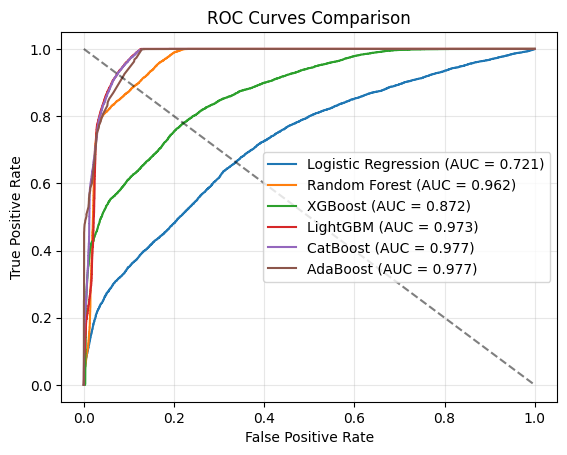

In [ ]:
#Comparing ROC curves
for name,result in results.items():
  fpr,tpr,_ = roc_curve(y_test,result['y_pred_proba'])
  plt.plot(fpr,tpr,label=f"{name} (AUC = {result['test_auc']:.3f})")

plt.plot([0,1],[1,0],'k--',alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True,alpha=0.3)

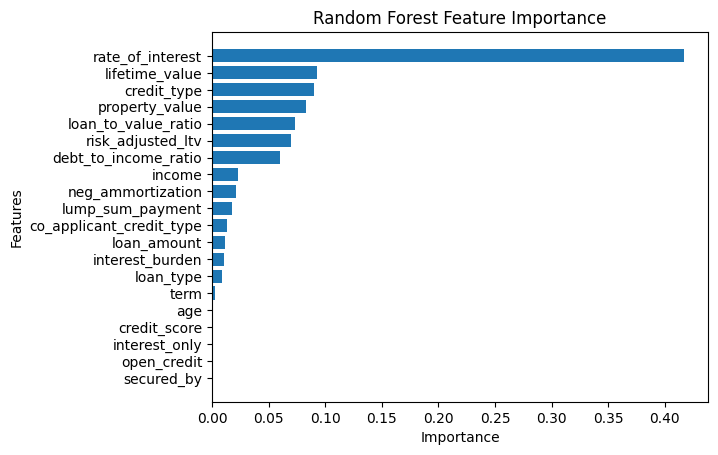

In [ ]:
#Feature importance for Random Forest
if 'Random Forest' in models:
  rf_model = models['Random Forest']
  feature_importance = pd.DataFrame({
      'feature': selected_features,
      'importance': rf_model.feature_importances_
  }).sort_values('importance',ascending=True)

  plt.barh(feature_importance['feature'],feature_importance['importance'])
  plt.xlabel('Importance')
  plt.ylabel('Features')
  plt.title('Random Forest Feature Importance')

plt.show()

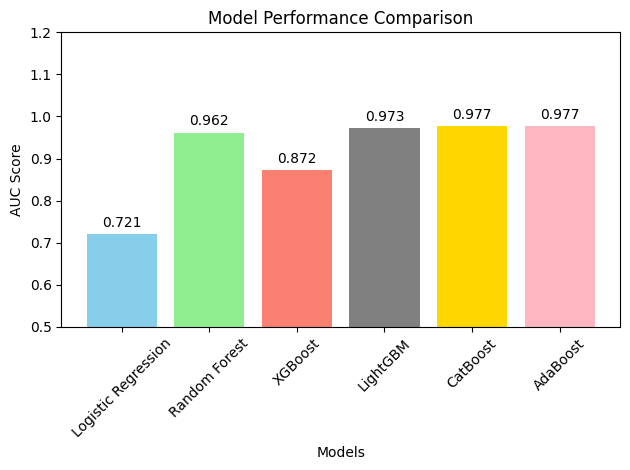

In [ ]:
model_names = list(results.keys())
auc_scores = [results[name]['test_auc'] for name in model_names]

colors = ['skyblue','lightgreen','salmon','grey','gold','lightpink']
bars = plt.bar(model_names,auc_scores,color = colors[:len(model_names)])
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.title('Model Performance Comparison')
plt.ylim(0.5,1.2)
plt.xticks(rotation=45)
for bar, score in zip(bars, auc_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Both Catboost and Adaboost has the highest model performance

In [ ]:
#Choosing the best model
best_model = max(results.keys(),key = lambda x: results[x]['test_auc'])
print(f"Best Model: {best_model} (AUC: {results[best_model]['test_auc']:.4f})")

Best Model: CatBoost (AUC: 0.9771)


In [ ]:
#choose the best model
best_model = models[best_model]
best_model

####Model Explainability

In [ ]:
import shap
import warnings
warnings.filterwarnings('ignore')

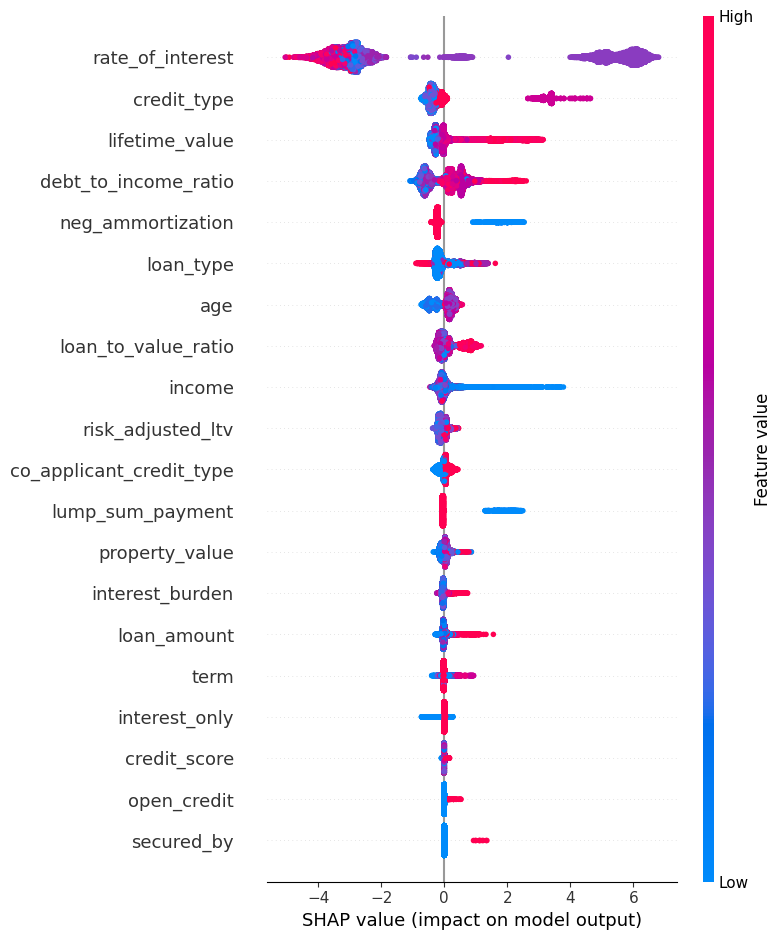

In [ ]:
#Shap analysis for catboost
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_processed)
shap.summary_plot(shap_values,X_test_processed)